https://randomrealizations.com/posts/xgboost-for-classification-in-python/

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn import datasets
import xgboost as xgb 

dbunch = datasets.load_breast_cancer(as_frame=True)
df = dbunch.frame
features = dbunch.feature_names 
target_names = dbunch.target_names 
target = 'target' 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [2]:
print(df[target].unique())
print(target_names)

[0 1]
['malignant' 'benign']


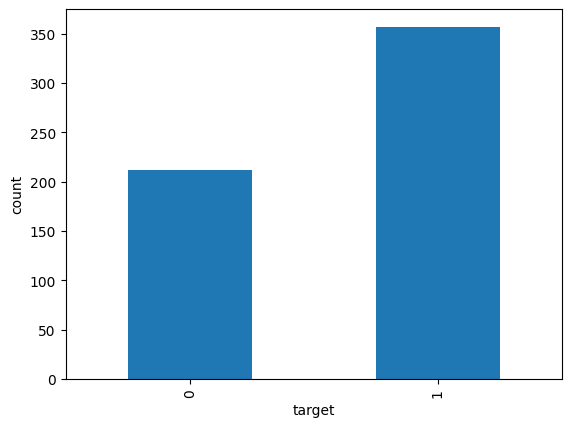

In [3]:
df.target.value_counts().sort_index().plot.bar()
plt.xlabel('target') 
plt.ylabel('count');

In [4]:
from sklearn.model_selection import train_test_split

n_valid = 50 

train_df, valid_df = train_test_split(df, test_size=n_valid, random_state=42)
train_df.shape, valid_df.shape

((519, 31), (50, 31))

In [5]:
params = {
    'tree_method': 'exact',
    'objective': 'binary:logistic',
}
num_boost_round = 50

dtrain = xgb.DMatrix(label=train_df[target], data=train_df[features])
dvalid = xgb.DMatrix(label=valid_df[target], data=valid_df[features])
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
                  evals=[(dtrain, 'train'), (dvalid, 'valid')],
                  verbose_eval=10)

[0]	train-logloss:0.43878	valid-logloss:0.44394
[10]	train-logloss:0.04281	valid-logloss:0.12501
[20]	train-logloss:0.01514	valid-logloss:0.11544
[30]	train-logloss:0.00961	valid-logloss:0.12818
[40]	train-logloss:0.00750	valid-logloss:0.13241
[49]	train-logloss:0.00659	valid-logloss:0.13585


In [6]:
params = {
    'tree_method': 'exact',
    'objective': 'binary:logistic',
}
num_boost_round = 50

clf = xgb.XGBClassifier(n_estimators=num_boost_round, **params)
clf.fit(train_df[features], train_df[target], 
        eval_set=[(train_df[features], train_df[target]), (valid_df[features], valid_df[target])], 
        verbose=10);

[0]	validation_0-logloss:0.43878	validation_1-logloss:0.44394
[10]	validation_0-logloss:0.04281	validation_1-logloss:0.12501
[20]	validation_0-logloss:0.01514	validation_1-logloss:0.11544
[30]	validation_0-logloss:0.00961	validation_1-logloss:0.12818
[40]	validation_0-logloss:0.00750	validation_1-logloss:0.13241
[49]	validation_0-logloss:0.00659	validation_1-logloss:0.13585


In [7]:
y_true = valid_df[target]
y_pred = clf.predict(valid_df[features])
y_score = clf.predict_proba(valid_df[features])[:,1]

In [8]:
from sklearn import metrics 

metrics.accuracy_score(y_true, y_pred)

0.96

In [9]:
print(metrics.classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   malignant       0.93      0.93      0.93        15
      benign       0.97      0.97      0.97        35

    accuracy                           0.96        50
   macro avg       0.95      0.95      0.95        50
weighted avg       0.96      0.96      0.96        50



In [10]:
metrics.roc_auc_score(y_true, y_score)

0.9885714285714285

In [11]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

scorer = make_scorer(metrics.log_loss, greater_is_better=False, needs_proba=True)
permu_imp = permutation_importance(clf, valid_df[features], valid_df[target], 
                                   n_repeats=30, random_state=0, scoring=scorer)

/Users/s/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


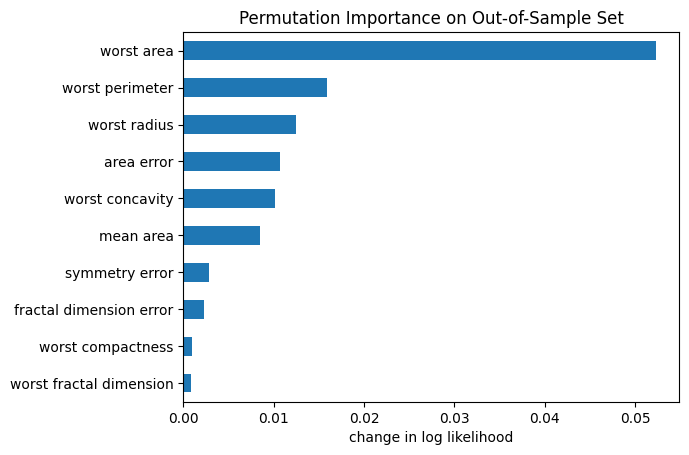

In [13]:
importances_permutation = pd.Series(permu_imp['importances_mean'], index=features)
importances_permutation.sort_values(ascending=True)[-10:].plot.barh()
plt.title('Permutation Importance on Out-of-Sample Set')
plt.xlabel('change in log likelihood');

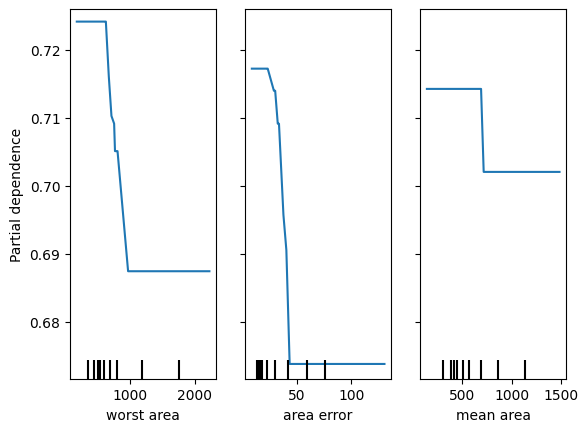

In [14]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(clf, 
                                        valid_df[features], 
                                        ['worst area', 'area error', 'mean area']);

#MULTI_CLASS CLASSIFICATION


In [15]:
dbunch = datasets.fetch_covtype(as_frame=True)
df = dbunch.frame
features = dbunch.feature_names 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           581012 non-null  float64
 1   Aspect                              581012 non-null  float64
 2   Slope                               581012 non-null  float64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  float64
 4   Vertical_Distance_To_Hydrology      581012 non-null  float64
 5   Horizontal_Distance_To_Roadways     581012 non-null  float64
 6   Hillshade_9am                       581012 non-null  float64
 7   Hillshade_Noon                      581012 non-null  float64
 8   Hillshade_3pm                       581012 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  float64
 10  Wilderness_Area_0                   581012 non-null  float64
 11  Wilderness_Area_1         

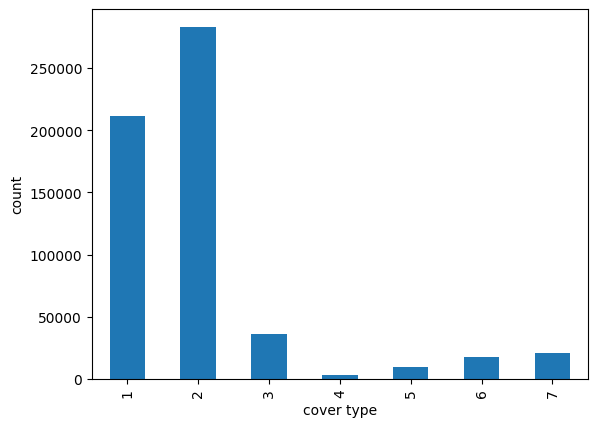

In [16]:
df['Cover_Type'].value_counts().sort_index().plot.bar()
plt.xlabel('cover type') 
plt.ylabel('count');

In [17]:
from sklearn.preprocessing import LabelEncoder 

target = 'encoded'
enc = LabelEncoder()
df[target] = enc.fit_transform(df['Cover_Type'])
print(np.sort(df[target].unique()))

[0 1 2 3 4 5 6]


In [18]:
n_valid = 20000

train_df, valid_df = train_test_split(df, test_size=n_valid, random_state=42)
train_df.shape, valid_df.shape

((561012, 56), (20000, 56))

In [19]:
params = {
    'tree_method': 'approx',
    'objective': 'multi:softprob',
    'num_class': df[target].nunique()
}
num_boost_round = 10

dtrain = xgb.DMatrix(label=train_df[target], data=train_df[features])
dvalid = xgb.DMatrix(label=valid_df[target], data=valid_df[features])
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
                  evals=[(dtrain, 'train'), (dvalid, 'valid')],
                  verbose_eval=2)

[0]	train-mlogloss:1.42032	valid-mlogloss:1.42366
[2]	train-mlogloss:1.00541	valid-mlogloss:1.00963
[4]	train-mlogloss:0.80557	valid-mlogloss:0.81109
[6]	train-mlogloss:0.69432	valid-mlogloss:0.70085
[8]	train-mlogloss:0.62653	valid-mlogloss:0.63350
[9]	train-mlogloss:0.60111	valid-mlogloss:0.60794


In [20]:
params = {
    'tree_method': 'approx',
    'objective': 'multi:softprob',
}
num_boost_round = 10

clf = xgb.XGBClassifier(n_estimators=num_boost_round, **params)
clf.fit(train_df[features], train_df[target], 
        eval_set=[(train_df[features], train_df[target]), (valid_df[features], valid_df[target])], 
        verbose=2);

[0]	validation_0-mlogloss:1.42032	validation_1-mlogloss:1.42366
[2]	validation_0-mlogloss:1.00541	validation_1-mlogloss:1.00963
[4]	validation_0-mlogloss:0.80557	validation_1-mlogloss:0.81109
[6]	validation_0-mlogloss:0.69432	validation_1-mlogloss:0.70085
[8]	validation_0-mlogloss:0.62653	validation_1-mlogloss:0.63350
[9]	validation_0-mlogloss:0.60111	validation_1-mlogloss:0.60794


In [21]:
y_true = valid_df[target]
y_pred = clf.predict(valid_df[features])
y_score = clf.predict_proba(valid_df[features])
y_true.shape, y_pred.shape, y_score.shape

((20000,), (20000,), (20000, 7))

In [28]:
y_score

array([[0.7356784 , 0.07117823, 0.02353812, ..., 0.02344529, 0.02344388,
        0.0992711 ],
       [0.0775875 , 0.7417476 , 0.03012988, ..., 0.07636608, 0.0340878 ,
        0.02011344],
       [0.02275465, 0.710728  , 0.07512002, ..., 0.0364964 , 0.11223667,
        0.02140973],
       ...,
       [0.68840855, 0.18757   , 0.0218705 , ..., 0.02178423, 0.02178293,
        0.03679987],
       [0.6728058 , 0.18243426, 0.02490799, ..., 0.02480975, 0.02480826,
        0.04542447],
       [0.12823598, 0.70292044, 0.01689998, ..., 0.10027475, 0.01787974,
        0.01695604]], dtype=float32)

In [29]:
y_pred

array([0, 1, 1, ..., 0, 0, 1])

In [22]:
metrics.accuracy_score(y_true, y_pred)

0.77425

In [23]:
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.74      0.75      7365
           1       0.78      0.84      0.81      9725
           2       0.75      0.85      0.80      1207
           3       0.82      0.78      0.80        85
           4       0.93      0.26      0.40       317
           5       0.76      0.31      0.44       627
           6       0.88      0.68      0.77       674

    accuracy                           0.77     20000
   macro avg       0.81      0.64      0.68     20000
weighted avg       0.78      0.77      0.77     20000



In [24]:
metrics.roc_auc_score(y_true, y_score, average='weighted', multi_class='ovr')

0.9129422094408693

In [25]:
scorer = make_scorer(metrics.log_loss, greater_is_better=False, needs_proba=True)
permu_imp = permutation_importance(clf, valid_df[features], valid_df[target], 
                                   n_repeats=30, random_state=0, scoring=scorer)

/Users/s/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


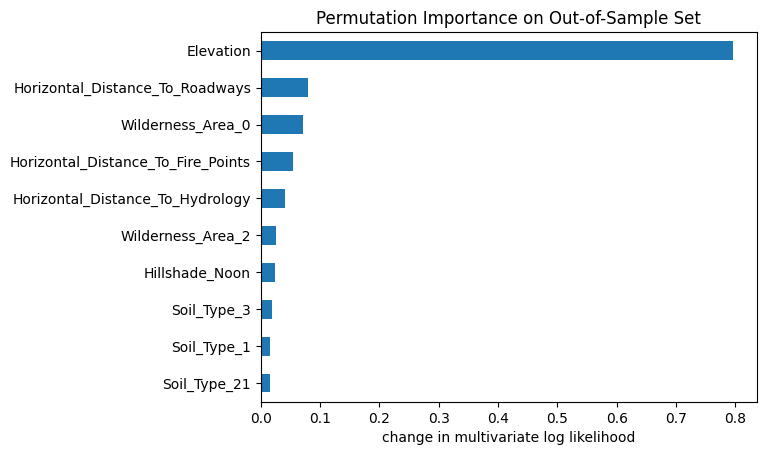

In [26]:
importances_permutation = pd.Series(permu_imp['importances_mean'], index=features)
importances_permutation.sort_values(ascending=True)[-10:].plot.barh()
plt.title('Permutation Importance on Out-of-Sample Set')
plt.xlabel('change in multivariate log likelihood');

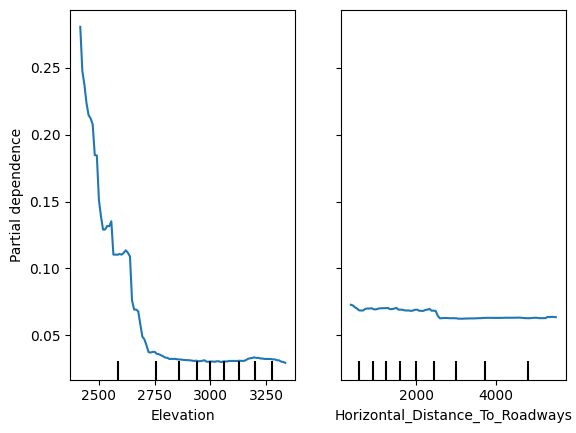

In [27]:
PartialDependenceDisplay.from_estimator(clf, 
                                        X=valid_df[features], 
                                        features=['Elevation', 'Horizontal_Distance_To_Roadways'], 
                                        target=enc.transform([3])[0]);